In [2]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report,accuracy_score
import joblib
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [3]:
data_tst=pd.read_csv("GUIDE_Test.csv")

<ipython-input-3-301d20c02d0f>:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_tst=pd.read_csv("GUIDE_Test.csv")


In [4]:
data_tst.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5.0,66.0,NaN,Suspicious,Suspicious,242.0,1445.0,10630.0,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0.0,0.0,NaN,Suspicious,Suspicious,242.0,1445.0,10630.0,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5.0,66.0,NaN,Suspicious,Suspicious,242.0,1445.0,10630.0,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5.0,66.0,NaN,NaN,NaN,242.0,1445.0,10630.0,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5.0,66.0,NaN,NaN,NaN,242.0,1445.0,10630.0,Public


In [5]:
list(data_tst.columns)  # full column view

['Id',
 'OrgId',
 'IncidentId',
 'AlertId',
 'Timestamp',
 'DetectorId',
 'AlertTitle',
 'Category',
 'MitreTechniques',
 'IncidentGrade',
 'ActionGrouped',
 'ActionGranular',
 'EntityType',
 'EvidenceRole',
 'DeviceId',
 'Sha256',
 'IpAddress',
 'Url',
 'AccountSid',
 'AccountUpn',
 'AccountObjectId',
 'AccountName',
 'DeviceName',
 'NetworkMessageId',
 'EmailClusterId',
 'RegistryKey',
 'RegistryValueName',
 'RegistryValueData',
 'ApplicationId',
 'ApplicationName',
 'OAuthApplicationId',
 'ThreatFamily',
 'FileName',
 'FolderPath',
 'ResourceIdName',
 'ResourceType',
 'Roles',
 'OSFamily',
 'OSVersion',
 'AntispamDirection',
 'SuspicionLevel',
 'LastVerdict',
 'CountryCode',
 'State',
 'City',
 'Usage']

In [6]:
pd.set_option('display.max_columns', None)
data_tst.head(1)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,NaN,NaN,User,Impacted,98799,138268,360606,160396.0,2610.0,3699.0,425863.0,863.0,153085.0,529644.0,NaN,1631.0,635.0,860.0,2251.0,3421.0,881.0,NaN,289573.0,117668.0,3586.0,NaN,NaN,5.0,66.0,NaN,Suspicious,Suspicious,242.0,1445.0,10630.0,Private


In [7]:
data_tst.shape

(607629, 46)

In [8]:
data_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607629 entries, 0 to 607628
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  607629 non-null  int64  
 1   OrgId               607629 non-null  int64  
 2   IncidentId          607629 non-null  int64  
 3   AlertId             607629 non-null  int64  
 4   Timestamp           607629 non-null  object 
 5   DetectorId          607629 non-null  int64  
 6   AlertTitle          607629 non-null  int64  
 7   Category            607629 non-null  object 
 8   MitreTechniques     269968 non-null  object 
 9   IncidentGrade       607629 non-null  object 
 10  ActionGrouped       309 non-null     object 
 11  ActionGranular      309 non-null     object 
 12  EntityType          607629 non-null  object 
 13  EvidenceRole        607629 non-null  object 
 14  DeviceId            607629 non-null  int64  
 15  Sha256              607629 non-nul

# Handling data

In [9]:
threshold= len(data_tst)* 0.5   # removing 50% above null value
data_tst=data_tst.dropna(thresh=threshold,axis=1)

In [10]:
data_tst.shape

(607629, 36)

In [11]:
data_tst.duplicated().sum()

5977

In [12]:
data_tst.drop_duplicates(inplace=True)

In [31]:
data_tst

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,LateralMovement,BenignPositive,User,Impacted,98799,138268,360606,160396.0,2610.0,3699.0,425863.0,863.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Private,4,6,2024,22,22:56:27
1,1400159342154,3,91158,632273,2,2,CommandAndControl,BenignPositive,Machine,Impacted,1239,138268,360606,160396.0,441377.0,673934.0,425863.0,453297.0,2833.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,0.0,0.0,242.0,1445.0,10630.0,Public,3,6,2024,12,12:58:26
2,1279900255923,145,32247,131719,2932,10807,LateralMovement,BenignPositive,Process,Related,98799,4296,360606,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,14.0,22.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public,8,6,2024,3,03:20:49
3,60129547292,222,15294,917686,0,0,InitialAccess,FalsePositive,CloudLogonSession,Related,98799,138268,360606,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public,12,6,2024,12,12:07:31
4,515396080539,363,7615,5944,27,18,Discovery,BenignPositive,User,Impacted,98799,138268,360606,160396.0,133549.0,673934.0,425863.0,136104.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public,6,6,2024,17,17:42:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607623,154618827719,162,19425,1469989,25,17,InitialAccess,TruePositive,User,Impacted,98799,138268,360606,160396.0,7.0,14.0,5.0,7.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public,5,6,2024,3,03:09:16
607624,1168231107034,5,25,915704,4,3,InitialAccess,TruePositive,User,Impacted,98799,138268,360606,160396.0,41.0,56.0,37.0,43.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public,10,6,2024,18,18:11:59
607625,154618826495,12,1465,1447,16,67,Impact,BenignPositive,Ip,Related,98799,138268,14944,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Private,19,5,2024,23,23:19:04
607627,240518173477,4,207,535,8,7,InitialAccess,FalsePositive,Machine,Impacted,98799,138268,360606,160396.0,441377.0,673934.0,425863.0,453297.0,306.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public,26,5,2024,18,18:33:28


In [15]:
data_tst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 601652 entries, 0 to 607628
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  601652 non-null  int64  
 1   OrgId               601652 non-null  int64  
 2   IncidentId          601652 non-null  int64  
 3   AlertId             601652 non-null  int64  
 4   Timestamp           601652 non-null  object 
 5   DetectorId          601652 non-null  int64  
 6   AlertTitle          601652 non-null  int64  
 7   Category            601652 non-null  object 
 8   IncidentGrade       601652 non-null  object 
 9   EntityType          601652 non-null  object 
 10  EvidenceRole        601652 non-null  object 
 11  DeviceId            601652 non-null  int64  
 12  Sha256              601652 non-null  int64  
 13  IpAddress           601652 non-null  int64  
 14  Url                 601651 non-null  float64
 15  AccountSid          601651 non-null  fl

In [29]:
#mode imputation because of catagorial columns

data_tst["IncidentGrade"].fillna(data_tst["IncidentGrade"].mode()[0],inplace=True)

<ipython-input-29-250e31f5011d>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_tst["IncidentGrade"].fillna(data_tst["IncidentGrade"].mode()[0],inplace=True)


In [16]:
data_tst['Timestamp']=pd.to_datetime(data_tst['Timestamp']) # data clean Timestamp

In [17]:
data_tst['Timestamp'].head()

,Timestamp
0,2024-06-04 22:56:27+00:00
1,2024-06-03 12:58:26+00:00
2,2024-06-08 03:20:49+00:00
3,2024-06-12 12:07:31+00:00
4,2024-06-06 17:42:05+00:00


In [18]:
data_tst["Day"]=data_tst["Timestamp"].dt.day
data_tst["Month"]=data_tst["Timestamp"].dt.month
data_tst["Year"]=data_tst["Timestamp"].dt.year
data_tst["Hour"]=data_tst["Timestamp"].dt.hour
data_tst["Time"]=data_tst["Timestamp"].dt.time

In [27]:
[features for features in data_tst.columns if data_tst[features].isnull().sum()>0]

['Url',
 'AccountSid',
 'AccountUpn',
 'AccountObjectId',
 'AccountName',
 'DeviceName',
 'NetworkMessageId',
 'RegistryKey',
 'RegistryValueName',
 'RegistryValueData',
 'ApplicationId',
 'ApplicationName',
 'OAuthApplicationId',
 'FileName',
 'FolderPath',
 'ResourceIdName',
 'OSFamily',
 'OSVersion',
 'CountryCode',
 'State',
 'City',
 'Usage']

In [19]:
data_tst.drop("Timestamp",axis=1,inplace=True)  # doprring timestamp column
print(data_tst.head())

              Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  \
0  1245540519230    657       11767    87199         524         563   
1  1400159342154      3       91158   632273           2           2   
2  1279900255923    145       32247   131719        2932       10807   
3    60129547292    222       15294   917686           0           0   
4   515396080539    363        7615     5944          27          18   

            Category   IncidentGrade         EntityType EvidenceRole  \
0    LateralMovement  BenignPositive               User     Impacted   
1  CommandAndControl  BenignPositive            Machine     Impacted   
2    LateralMovement  BenignPositive            Process      Related   
3      InitialAccess   FalsePositive  CloudLogonSession      Related   
4          Discovery  BenignPositive               User     Impacted   

   DeviceId  Sha256  IpAddress       Url  AccountSid  AccountUpn  \
0     98799  138268     360606  160396.0      2610.0      3699.0  

In [20]:
pd.set_option("display.max_columns", None)
data_tst.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,LateralMovement,BenignPositive,User,Impacted,98799,138268,360606,160396.0,2610.0,3699.0,425863.0,863.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Private,4,6,2024,22,22:56:27
1,1400159342154,3,91158,632273,2,2,CommandAndControl,BenignPositive,Machine,Impacted,1239,138268,360606,160396.0,441377.0,673934.0,425863.0,453297.0,2833.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,0.0,0.0,242.0,1445.0,10630.0,Public,3,6,2024,12,12:58:26
2,1279900255923,145,32247,131719,2932,10807,LateralMovement,BenignPositive,Process,Related,98799,4296,360606,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,14.0,22.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public,8,6,2024,3,03:20:49
3,60129547292,222,15294,917686,0,0,InitialAccess,FalsePositive,CloudLogonSession,Related,98799,138268,360606,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public,12,6,2024,12,12:07:31
4,515396080539,363,7615,5944,27,18,Discovery,BenignPositive,User,Impacted,98799,138268,360606,160396.0,133549.0,673934.0,425863.0,136104.0,153085.0,529644.0,1631.0,635.0,860.0,2251.0,3421.0,881.0,289573.0,117668.0,3586.0,5.0,66.0,242.0,1445.0,10630.0,Public,6,6,2024,17,17:42:05


In [21]:
data_tst['IncidentGrade'].value_counts()

,count
IncidentGrade,
BenignPositive,254096
TruePositive,216668
FalsePositive,130888


In [22]:
data_tst.IncidentGrade.unique()

array(['BenignPositive', 'FalsePositive', 'TruePositive'], dtype=object)

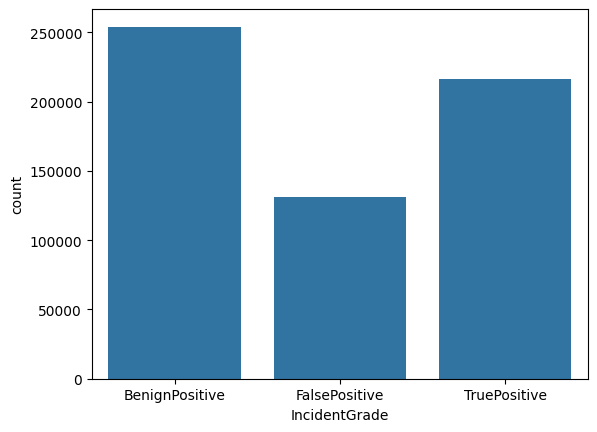

In [24]:
# Distribution of target variable
sns.countplot(x="IncidentGrade", data=data_tst)
plt.show()

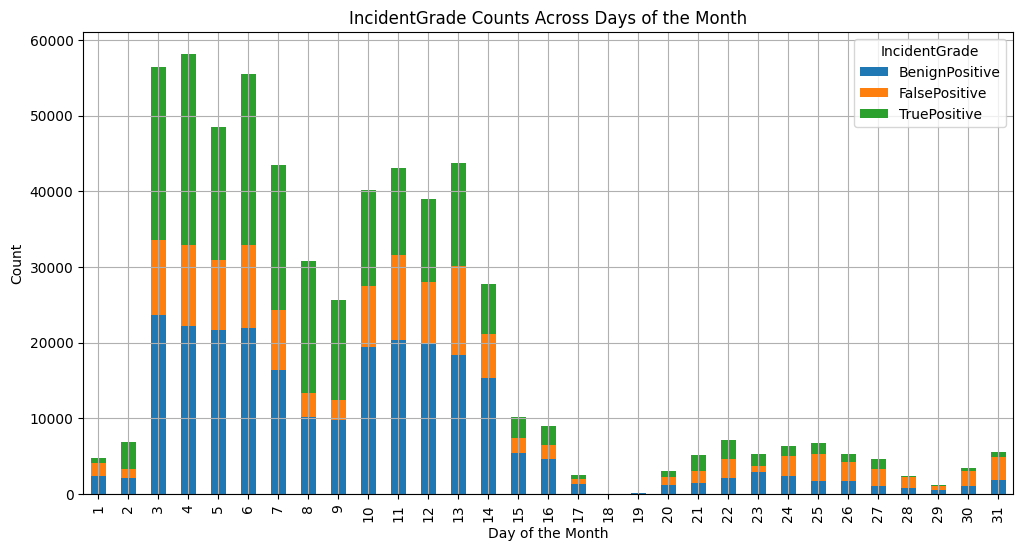

In [25]:
# Aggregate data
day_incident_grade = data_tst.groupby(['Day', 'IncidentGrade']).size().unstack()

# Plot
day_incident_grade.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.title('IncidentGrade Counts Across Days of the Month')
plt.legend(title='IncidentGrade')
plt.grid(True)
plt.show()

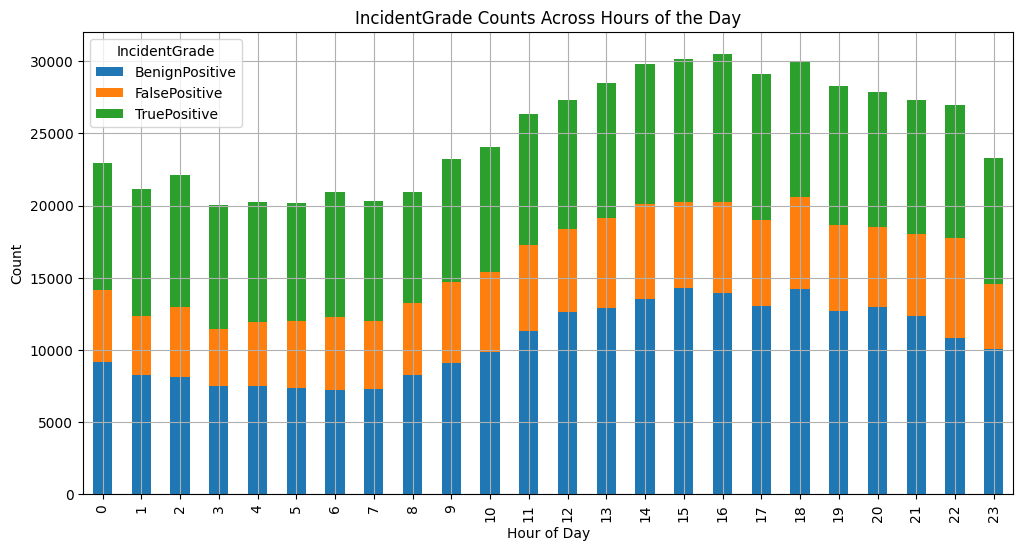

In [26]:
# Aggregate data

hour_incident =data_tst.groupby(['Hour', 'IncidentGrade']).size().unstack()

hour_incident.plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel("Hour of Day")
plt.ylabel('Count')
plt.title('IncidentGrade Counts Across Hours of the Day')
plt.legend(title="IncidentGrade")
plt.grid(True)
plt.show()

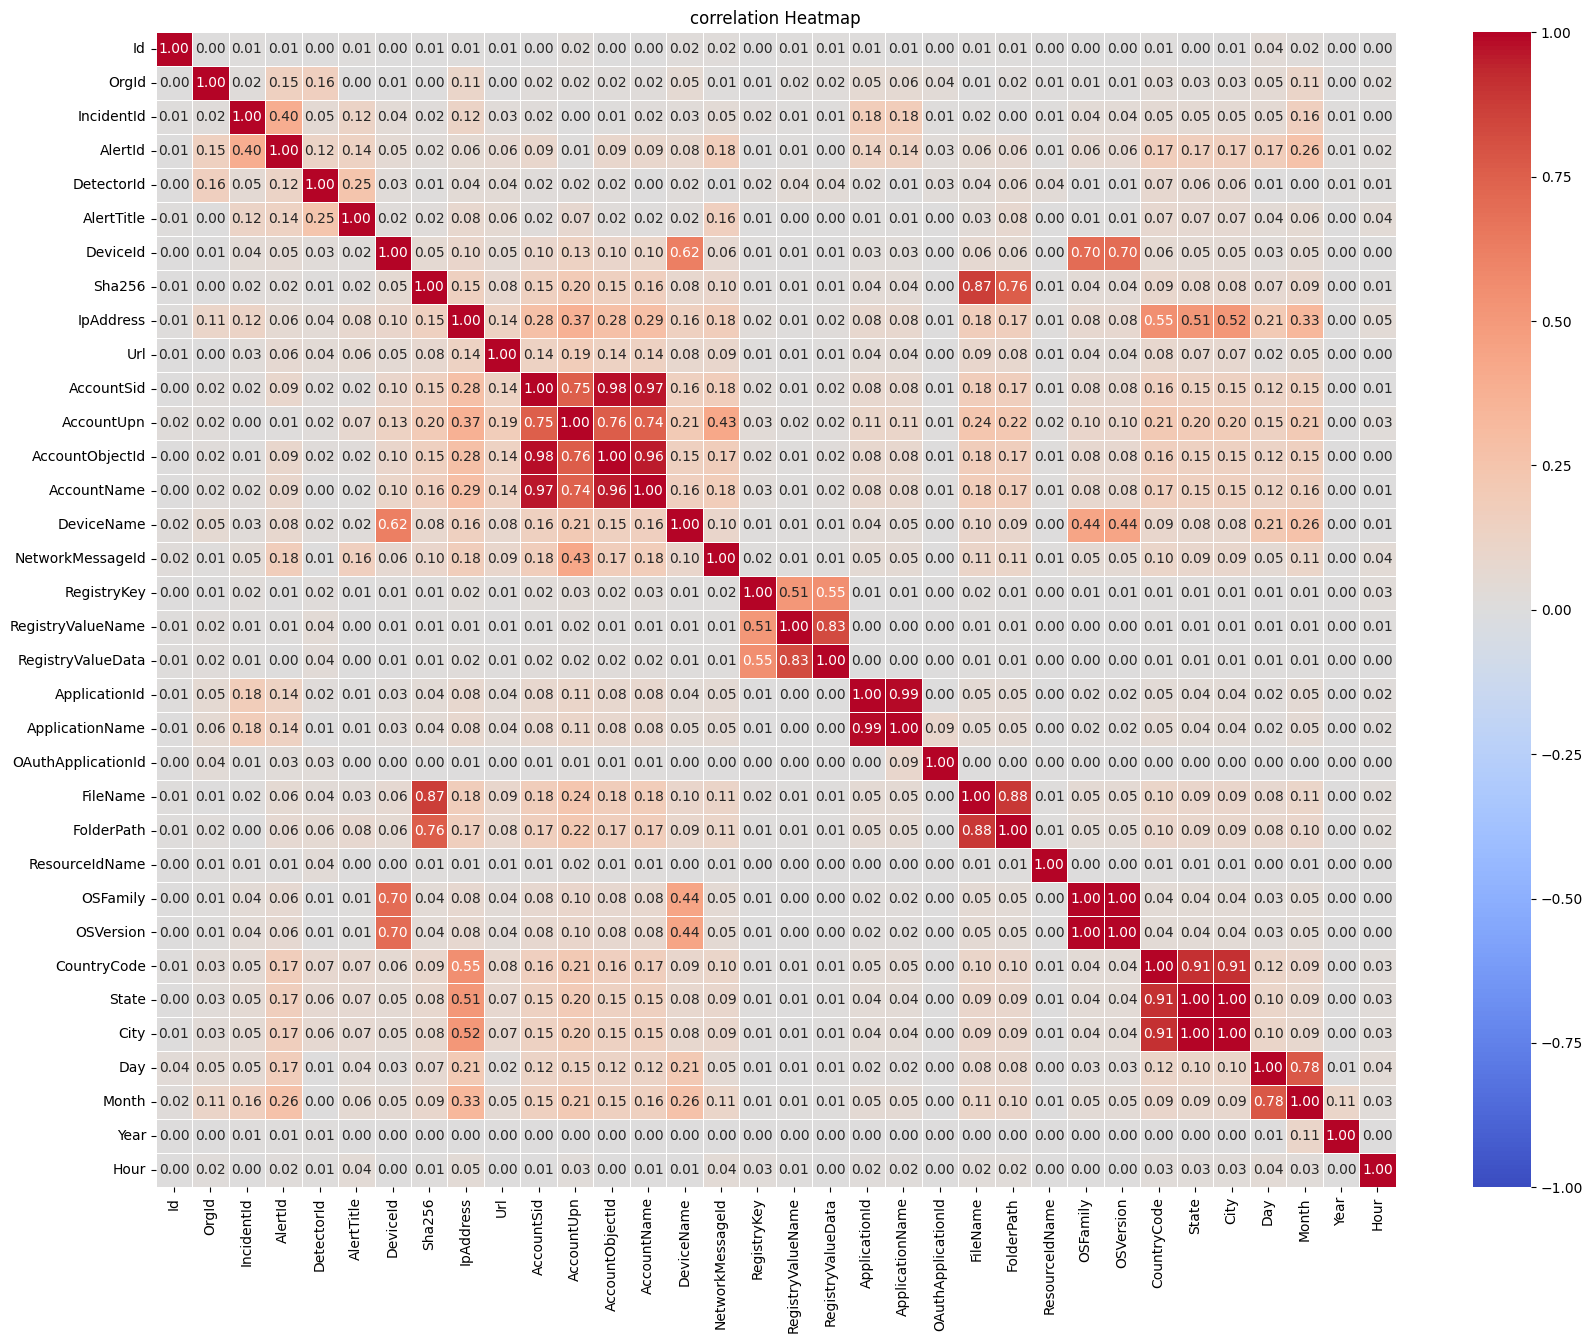

In [32]:
# selecting numerical col
numeric_df=data_tst.select_dtypes(include=['number'])

corr_matrix= numeric_df.corr().abs()

# plot the heatmap
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, linewidths=0.5)
plt.title('correlation Heatmap')
plt.show()

In [33]:
# dropping 70% above correlated columns
data_tst.drop(["CountryCode","Sha256","ApplicationName","RegistryValueName","AccountSid","OSFamily","OSVersion","AccountObjectId","State","FolderPath","AccountUpn"], axis =1 , inplace = True)

In [35]:
data_tst

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationId,OAuthApplicationId,FileName,ResourceIdName,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,LateralMovement,BenignPositive,User,Impacted,98799,360606,160396.0,863.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Private,4,6,2024,22,22:56:27
1,1400159342154,3,91158,632273,2,2,CommandAndControl,BenignPositive,Machine,Impacted,1239,360606,160396.0,453297.0,2833.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Public,3,6,2024,12,12:58:26
2,1279900255923,145,32247,131719,2932,10807,LateralMovement,BenignPositive,Process,Related,98799,360606,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,14.0,3586.0,10630.0,Public,8,6,2024,3,03:20:49
3,60129547292,222,15294,917686,0,0,InitialAccess,FalsePositive,CloudLogonSession,Related,98799,360606,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Public,12,6,2024,12,12:07:31
4,515396080539,363,7615,5944,27,18,Discovery,BenignPositive,User,Impacted,98799,360606,160396.0,136104.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Public,6,6,2024,17,17:42:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607623,154618827719,162,19425,1469989,25,17,InitialAccess,TruePositive,User,Impacted,98799,360606,160396.0,7.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Public,5,6,2024,3,03:09:16
607624,1168231107034,5,25,915704,4,3,InitialAccess,TruePositive,User,Impacted,98799,360606,160396.0,43.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Public,10,6,2024,18,18:11:59
607625,154618826495,12,1465,1447,16,67,Impact,BenignPositive,Ip,Related,98799,14944,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Private,19,5,2024,23,23:19:04
607627,240518173477,4,207,535,8,7,InitialAccess,FalsePositive,Machine,Impacted,98799,360606,160396.0,453297.0,306.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,Public,26,5,2024,18,18:33:28


In [ ]:
# Encoding

In [36]:
data_tst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 601652 entries, 0 to 607628
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  601652 non-null  int64  
 1   OrgId               601652 non-null  int64  
 2   IncidentId          601652 non-null  int64  
 3   AlertId             601652 non-null  int64  
 4   DetectorId          601652 non-null  int64  
 5   AlertTitle          601652 non-null  int64  
 6   Category            601652 non-null  object 
 7   IncidentGrade       601652 non-null  object 
 8   EntityType          601652 non-null  object 
 9   EvidenceRole        601652 non-null  object 
 10  DeviceId            601652 non-null  int64  
 11  IpAddress           601652 non-null  int64  
 12  Url                 601651 non-null  float64
 13  AccountName         601651 non-null  float64
 14  DeviceName          601651 non-null  float64
 15  NetworkMessageId    601651 non-null  fl

In [37]:
data_tst.select_dtypes(include=["object"]).columns

Index(['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'Usage',
       'Time'],
      dtype='object')

In [38]:
Categorical_colts=['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'Usage',
       'Time']

In [ ]:
# Label encoder

In [40]:
encoders = {}
for i in Categorical_colts:
    le = LabelEncoder()
    data_tst[i]=le.fit_transform(data_tst[i])
    encoders[i]=le

In [41]:
data_tst

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationId,OAuthApplicationId,FileName,ResourceIdName,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,11,0,24,0,98799,360606,160396.0,863.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,0,4,6,2024,22,80291
1,1400159342154,3,91158,632273,2,2,1,0,11,0,1239,360606,160396.0,453297.0,2833.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,3,6,2024,12,44964
2,1279900255923,145,32247,131719,2932,10807,11,0,19,1,98799,360606,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,14.0,3586.0,10630.0,1,8,6,2024,3,11613
3,60129547292,222,15294,917686,0,0,10,1,6,1,98799,360606,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,12,6,2024,12,41959
4,515396080539,363,7615,5944,27,18,5,0,24,0,98799,360606,160396.0,136104.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,6,6,2024,17,61773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607623,154618827719,162,19425,1469989,25,17,10,2,24,0,98799,360606,160396.0,7.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,5,6,2024,3,10947
607624,1168231107034,5,25,915704,4,3,10,2,24,0,98799,360606,160396.0,43.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,10,6,2024,18,63553
607625,154618826495,12,1465,1447,16,67,9,0,10,1,98799,14944,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,0,19,5,2024,23,81613
607627,240518173477,4,207,535,8,7,10,1,11,0,98799,360606,160396.0,453297.0,306.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,26,5,2024,18,64825


In [42]:
data_tst.select_dtypes(include=["int32", "int64"]).columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'IpAddress', 'Usage', 'Day', 'Month', 'Year', 'Hour', 'Time'],
      dtype='object')

In [43]:
data_tst1=data_tst.copy()

In [45]:
data_tst1.to_csv('/content/mtest_process.csv',index= False)

In [46]:
data_tst1.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationId,OAuthApplicationId,FileName,ResourceIdName,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,11,0,24,0,98799,360606,160396.0,863.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,0,4,6,2024,22,80291
1,1400159342154,3,91158,632273,2,2,1,0,11,0,1239,360606,160396.0,453297.0,2833.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,3,6,2024,12,44964
2,1279900255923,145,32247,131719,2932,10807,11,0,19,1,98799,360606,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,14.0,3586.0,10630.0,1,8,6,2024,3,11613
3,60129547292,222,15294,917686,0,0,10,1,6,1,98799,360606,160396.0,453297.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,12,6,2024,12,41959
4,515396080539,363,7615,5944,27,18,5,0,24,0,98799,360606,160396.0,136104.0,153085.0,529644.0,1631.0,860.0,2251.0,881.0,289573.0,3586.0,10630.0,1,6,6,2024,17,61773


In [47]:
from imblearn.over_sampling import RandomOverSampler

In [48]:
os =RandomOverSampler(random_state = 45)

In [50]:
val =data_tst1.drop('IncidentGrade', axis =1)

In [51]:
tar = data_tst1['IncidentGrade']

In [52]:
tar.value_counts()

,count
IncidentGrade,
0,254096
2,216668
1,130888


In [53]:
oval,otar = os.fit_resample(val,tar)

In [54]:
otar.value_counts()

,count
IncidentGrade,
0,254096
1,254096
2,254096


In [ ]:
# feature selection

In [56]:
fs = RandomForestClassifier(n_estimators = 300, random_state =56)

In [57]:
fs.fit(oval,otar)

RandomForestClassifier(n_estimators=300, random_state=56)

In [58]:
pd.DataFrame({
    "columns": oval.columns,
    "Score": fs.feature_importances_
}).sort_values('Score', ascending =False).head(15)["columns"].to_list()

['OrgId',
 'IncidentId',
 'DetectorId',
 'AlertId',
 'AlertTitle',
 'Id',
 'Day',
 'Category',
 'Time',
 'Hour',
 'AccountName',
 'EntityType',
 'IpAddress',
 'DeviceName',
 'FileName']

In [59]:
oval=oval[['OrgId',
 'IncidentId',
 'DetectorId',
 'AlertId',
 'AlertTitle',
 'Id',
 'Day',
 'Category',
 'Time',
 'Hour',
 'AccountName',
 'EntityType',
 'IpAddress',
 'DeviceName',
 'FileName']]

In [60]:
# Train Test Split
traindata,testdata, trainlab,testlab = train_test_split(oval,otar, test_size = 0.20, random_state = 43)

In [61]:
traindata.shape

(609830, 15)

In [62]:
testdata.shape

(152458, 15)

In [63]:
# Model building

In [64]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import xgboost

In [65]:
dt_model= DecisionTreeClassifier(max_depth=8,random_state=100,min_samples_split=10,min_samples_leaf=5,max_features="sqrt")

In [66]:
dt_model.fit(traindata,trainlab)

DecisionTreeClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10, random_state=100)

In [67]:
def metrics(actual, predicted):
    acc = accuracy_score(actual, predicted) * 100
    prec = precision_score(actual, predicted, average="macro") * 100
    recall = recall_score(actual, predicted, average="macro") * 100
    macro_f1 = f1_score(actual, predicted, average="macro") * 100

    return pd.DataFrame({
        "Metrics": ["Accuracy", "Precision", "Recall", "Macro F1"],
        "Values": [acc, prec, recall, macro_f1]
    }).set_index("Metrics")

In [68]:
dttr_pred =dt_model.predict(traindata)
dtts_pred =dt_model.predict(testdata)

In [69]:
dttrain_metrics=metrics(trainlab,dttr_pred)

In [70]:

dttest_metrics=metrics(testlab,dtts_pred)

In [71]:
pd.DataFrame({
    "Training":dttrain_metrics["Values"],
    "Testing":dttest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,67.748881,67.417256
1,Precision,71.785083,71.476351
2,Recall,67.744985,67.432492
3,Macro F1,68.030235,67.678506


In [72]:
# RANDOM FOREST
rfc =RandomForestClassifier(criterion='entropy',max_depth=10,n_estimators=200,n_jobs=-1,random_state=100)

In [73]:

rfc.fit(traindata,trainlab)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=100)

In [74]:
rftr_pred =rfc.predict(traindata)
rfts_pred =rfc.predict(testdata)

In [75]:
rftrain_metrics=metrics(trainlab,rftr_pred)
rftest_metrics=metrics(testlab,rfts_pred)

In [76]:
pd.DataFrame({
    "Training":rftrain_metrics["Values"],
    "Testing":rftest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,80.111506,79.872489
1,Precision,85.092147,84.843471
2,Recall,80.108145,79.886187
3,Macro F1,80.497379,80.241211


In [ ]:
# XGBoost

In [77]:
# XGBoost
xgbmodel = xgboost.XGBClassifier(n_estimators=200,learning_rate=0.1,random_state=100,n_jobs=-1,max_depth=8)

In [78]:
xgbmodel.fit(traindata,trainlab)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [79]:
xgbtr_pred =xgbmodel.predict(traindata)
xgbts_pred =xgbmodel.predict(testdata)

In [80]:
xgbtrain_metrics = metrics(trainlab,xgbtr_pred)
xgbtest_metrics =metrics(testlab,xgbts_pred)

In [81]:
pd.DataFrame({
    "Training":xgbtrain_metrics["Values"],
    "Testing":xgbtest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,94.444353,93.913734
1,Precision,94.489645,93.956109
2,Recall,94.443141,93.918410
3,Macro F1,94.449696,93.918314
